In [1]:
%cd ..

/home/ww2135/research/multimodal-baby


In [2]:
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12), 'axes.grid': True, 'axes.facecolor': 'white', 'figure.facecolor': 'white', 'font.family': 'monospace'})
from PIL import Image
from collections import Counter
from multimodal.multimodal_data_module import MultiModalSAYCamDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID
from train import _setup_parser

from math import exp

def batch_fill(x, n):
    return [x for i in range(n)]

def batch_add(a, b):
    for i, y in enumerate(b):
        a[i] += y

def batch_sub(a, b):
    for i, y in enumerate(b):
        a[i] -= y

def print_perplexities(cnts_losses_list, print_indices):
    formatter = lambda name, values: f'{name:>14}: ' + ' '.join(f'{value:12.6f}' for value in values)
    for i in print_indices:
        print(formatter(text_encoder.idx2word[i], (exp(losses[i]) for cnts, losses in cnts_losses_list)))
    print()
    tot_ = batch_fill(0, len(cnts_losses_list))
    tot_loss_ = batch_fill(0., len(cnts_losses_list))
    for i in range(0, vocab_size):
        if i not in [PAD_TOKEN_ID]:
            batch_add(tot_, (cnts[i] for cnts, losses in cnts_losses_list))
            batch_add(tot_loss_, (cnts[i] * losses[i] if cnts[i] else 0. for cnts, losses in cnts_losses_list))
    print(formatter("ppl", (exp(tot_loss / tot) for tot, tot_loss in zip(tot_, tot_loss_))))
    batch_sub(tot_, (cnts[SOS_TOKEN_ID] for cnts, losses in cnts_losses_list))
    batch_sub(tot_loss_, (cnts[SOS_TOKEN_ID] * losses[SOS_TOKEN_ID] for cnts, losses in cnts_losses_list))
    print(formatter("ppl_wo_sos", (exp(tot_loss / tot) for tot, tot_loss in zip(tot_, tot_loss_))))
    batch_sub(tot_, (cnts[EOS_TOKEN_ID] for cnts, losses in cnts_losses_list))
    batch_sub(tot_loss_, (cnts[EOS_TOKEN_ID] * losses[EOS_TOKEN_ID] for cnts, losses in cnts_losses_list))
    print(formatter("ppl_wo_sos_eos", (exp(tot_loss / tot) for tot, tot_loss in zip(tot_, tot_loss_))))

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
parser = _setup_parser()
args = parser.parse_args("")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = MultiModalSAYCamDataModule(args)
data.prepare_data()
data.setup()

checkpoint = [
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=12.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_128_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=223.ckpt",
    "checkpoints/lm_embedding_type_spatial_text_encoder_lstm_dropout_i_0.1_dropout_o_0.1_batch_size_16/epoch=91.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_lr_0.03_dropout_o_0.1_batch_size_128/epoch=20.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_lr_0.03_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_128_seed_1/epoch=32.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_lr_0.03_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_128_seed_2/epoch=29.ckpt",
    "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_lr_0.03_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_128/epoch=12.ckpt",
    "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_lr_0.03_crange_2_dropout_i_0.0_dropout_o_0.1_batch_size_128/epoch=11.ckpt",
][0]
lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
lit_model.to(device)
text_encoder = lit_model.text_encoder
"""
checkpoint = [
    "checkpoints/multimodal_unilstm_spatial_dim_512_batch_size_8_lr_0.0003/epoch=5.ckpt",
    "checkpoints/multimodal_bilstm_spatial_dim_512_batch_size_8_lr_0.0003/epoch=4.ckpt",
][0]
lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
lit_model.to(device)
print(lit_model.args)
text_encoder = lit_model.model.text_embed
"""

vocab = text_encoder.vocab
vocab_size = len(vocab)
print(f'vocab_size = {vocab_size}')
for idx in range(vocab_size):
    assert idx in text_encoder.idx2word
lit_model.eval()

Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 5589


MultiModalLitModel(
  (vision_encoder): VisionEncoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [4]:
from tqdm import tqdm
from nltk.tag import pos_tag

def get_mean_values(dataloader, get_value_level="vectors"):
    with torch.no_grad():
        cnt_pos = [Counter() for idx in range(vocab_size)]
        cnts = torch.zeros(vocab_size, dtype=torch.int, device=device)
        sum_vectors = torch.zeros(vocab_size, text_encoder.hidden_dim, device=device)
        sum_losses = torch.zeros(vocab_size, dtype=torch.float, device=device)

        for x, y, y_len in tqdm(dataloader):
            for i in range(y.size(0)):
                utterance_idxes = y[i, :y_len[i]].tolist()
                utterance_words = [text_encoder.idx2word[idx] for idx in utterance_idxes]
                tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if word not in ['<sos>', '<eos>']])
                _, pos_tags = zip(*pos_tag(tagging_words))
                utterance_pos_tags = ['.'] * int(y_len[i])
                for index, pos in zip(tagging_indices, pos_tags):
                    utterance_pos_tags[index] = pos
                for idx, pos in zip(utterance_idxes, utterance_pos_tags):
                    cnt_pos[idx].update({pos: 1})
            y, y_len = y.to(device=device), y_len.to(device=device)
            if get_value_level == "vectors":
                outputs = text_encoder(y, y_len)
            elif get_value_level == "losses":
                loss, outputs, logits, labels = lit_model.language_model.calculate_ce_loss(y, y_len, tokenwise=True)
            cnts.index_add_(0, y.reshape((-1,)), torch.ones_like(y, dtype=torch.int).reshape((-1,)).detach())
            if get_value_level in ["vectors", "losses"]:
                sum_vectors.index_add_(0, y.reshape((-1,)), outputs.reshape((-1, outputs.size(-1))).detach())
            if get_value_level == "losses":
                sum_losses.index_add_(0, labels.reshape((-1,)), loss.reshape((-1,)).detach())

        mean_vectors = sum_vectors / cnts.unsqueeze(-1)
        vectors = mean_vectors
        mean_losses = sum_losses / cnts

    return cnt_pos, cnts.cpu().numpy(), vectors.cpu().numpy(), mean_losses.cpu().numpy()

cnt_pos, cnts, vectors, losses = get_mean_values(data.train_dataloader(), get_value_level="losses")
#vectors = texprint_perplexities(losses, print_indices)t_encoder.embedding.weight.detach().cpu().numpy()
pos_of_idx = [pos_counter.most_common(1)[0][0] if pos_counter else '.' for pos_counter in cnt_pos]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8289/8289 [01:13<00:00, 112.59it/s]


In [5]:
print_perplexities([(cnts, losses)], range(20))

         <pad>:     1.000000
         <unk>:   519.097334
         <sos>:     1.000000
         <eos>:     2.151908
       alright:    78.235169
          lets:   465.522237
        change:   728.733863
          your:    22.990598
         nappy:    41.398688
        though:   292.295109
         first:   716.925318
          yeah:    12.453100
            oh:    40.520160
           you:     7.618190
         wanna:    94.215542
            do:    34.647138
            it:    10.772795
             i:    34.351286
         think:    15.719401
         there:    49.373393

           ppl:    20.818901
    ppl_wo_sos:    34.362090
ppl_wo_sos_eos:    59.109579


In [8]:
tokens = input().split()
token_ids = []
print('not found:', end='')
for s in tokens:
    try:
        token_ids.append(text_encoder.word2idx[s])
    except KeyError:
        print(f' {s}')
print()
np.set_printoptions(precision=2)
V = vectors[token_ids]
V = V / np.linalg.norm(V, axis=1, keepdims=True)
print(V @ V.T)
# do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
# do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled
# do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling
# do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't
# red orange yellow green blue purple brown black white

do does go goes play plays get gets eat eats have has
not found:
[[1.   0.58 0.25 0.18 0.39 0.36 0.43 0.5  0.62 0.38 0.49 0.32]
 [0.58 1.   0.22 0.36 0.13 0.37 0.31 0.29 0.49 0.58 0.41 0.44]
 [0.25 0.22 1.   0.5  0.6  0.26 0.52 0.3  0.45 0.18 0.24 0.05]
 [0.18 0.36 0.5  1.   0.49 0.17 0.33 0.27 0.33 0.34 0.2  0.3 ]
 [0.39 0.13 0.6  0.49 1.   0.21 0.5  0.29 0.61 0.34 0.23 0.13]
 [0.36 0.37 0.26 0.17 0.21 1.   0.25 0.32 0.37 0.32 0.52 0.2 ]
 [0.43 0.31 0.52 0.33 0.5  0.25 1.   0.37 0.74 0.42 0.65 0.46]
 [0.5  0.29 0.3  0.27 0.29 0.32 0.37 1.   0.46 0.26 0.32 0.13]
 [0.62 0.49 0.45 0.33 0.61 0.37 0.74 0.46 1.   0.56 0.67 0.48]
 [0.38 0.58 0.18 0.34 0.34 0.32 0.42 0.26 0.56 1.   0.41 0.16]
 [0.49 0.41 0.24 0.2  0.23 0.52 0.65 0.32 0.67 0.41 1.   0.7 ]
 [0.32 0.44 0.05 0.3  0.13 0.2  0.46 0.13 0.48 0.16 0.7  1.  ]]


In [10]:
tokens = input().split()
assert len(tokens) % 2 == 0
token_ids = []
ok = True
print('not found:', end='')
for s in tokens:
    try:
        token_ids.append(text_encoder.word2idx[s])
    except KeyError:
        print(f' {s}')
        ok = False
print()
if ok:
    np.set_printoptions(precision=2, suppress=True)
    V = vectors[token_ids]
    V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
    V = V[:, 1] - V[:, 0]
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    print(V @ V.T)
# boy girl mommy daddy grandpa grandma

boy girl mommy daddy grandpa grandma
not found:
[[ 1.   -0.16  0.29]
 [-0.16  1.   -0.17]
 [ 0.29 -0.17  1.  ]]


In [11]:
cnts[0] = 0

selected = cnts >= 100
selected_indices = np.arange(len(vectors))[selected]
n_samples = len(selected_indices)
print(n_samples)

222


In [12]:
selected_vectors = vectors[selected]

selected_words_and_pos_tags = [(text_encoder.idx2word[idx], pos_of_idx[idx]) for idx in selected_indices]
print(selected_words_and_pos_tags[:50])
selected_words, selected_pos_tags = zip(*selected_words_and_pos_tags)
for word in ['need', 'draw']:
    idx = text_encoder.word2idx[word]
    print(f'{word}: {pos_of_idx[idx]}')

[('<unk>', 'NN'), ('<sos>', '.'), ('<eos>', '.'), ('alright', 'NN'), ('lets', 'NNS'), ('your', 'PRP$'), ('nappy', 'JJ'), ('though', 'IN'), ('first', 'RB'), ('yeah', 'NN'), ('oh', 'UH'), ('you', 'PRP'), ('wanna', 'VBP'), ('do', 'VBP'), ('it', 'PRP'), ('i', 'NN'), ('think', 'VBP'), ('there', 'EX'), ('might', 'MD'), ('be', 'VB'), ('some', 'DT'), ('pretty', 'RB'), ('have', 'VBP'), ('to', 'TO'), ('draw', 'VB'), ('on', 'IN'), ('want', 'VBP'), ('that', 'DT'), ('ok', 'NN'), ("let's", 'NN'), ('find', 'VB'), ('shoes', 'NNS'), ('sam', 'NN'), ('where', 'WRB'), ('are', 'VBP'), ('this', 'DT'), ('up', 'RP'), ('so', 'RB'), ('all', 'DT'), ('off', 'RP'), ('we', 'PRP'), ('can', 'MD'), ('eat', 'VB'), ('say', 'VB'), ('kitty', 'NN'), ('maybe', 'RB'), ('else', 'RB'), ('will', 'MD'), ('get', 'VB'), ('no', 'DT')]
need: VBP
draw: VB


In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(selected_vectors, method='average', metric='cosine')

print(Z.shape)

(221, 4)


In [14]:
seed_0_losses = losses
#print_perplexities([(cnts, lstm_losses), (cnts, cbow_losses)], range(20))
print_perplexities([(cnts, seed_0_losses), (cnts, seed_0_losses)], range(20))

         <pad>:     1.000000     1.000000
         <unk>:   519.097334   519.097334
         <sos>:     1.000000     1.000000
         <eos>:     2.151908     2.151908
       alright:    78.235169    78.235169
          lets:   465.522237   465.522237
        change:   728.733863   728.733863
          your:    22.990598    22.990598
         nappy:    41.398688    41.398688
        though:   292.295109   292.295109
         first:   716.925318   716.925318
          yeah:    12.453100    12.453100
            oh:    40.520160    40.520160
           you:     7.618190     7.618190
         wanna:    94.215542    94.215542
            do:    34.647138    34.647138
            it:    10.772795    10.772795
             i:    34.351286    34.351286
         think:    15.719401    15.719401
         there:    49.373393    49.373393

           ppl:    20.818901    20.818901
    ppl_wo_sos:    34.362090    34.362090
ppl_wo_sos_eos:    59.109579    59.109579


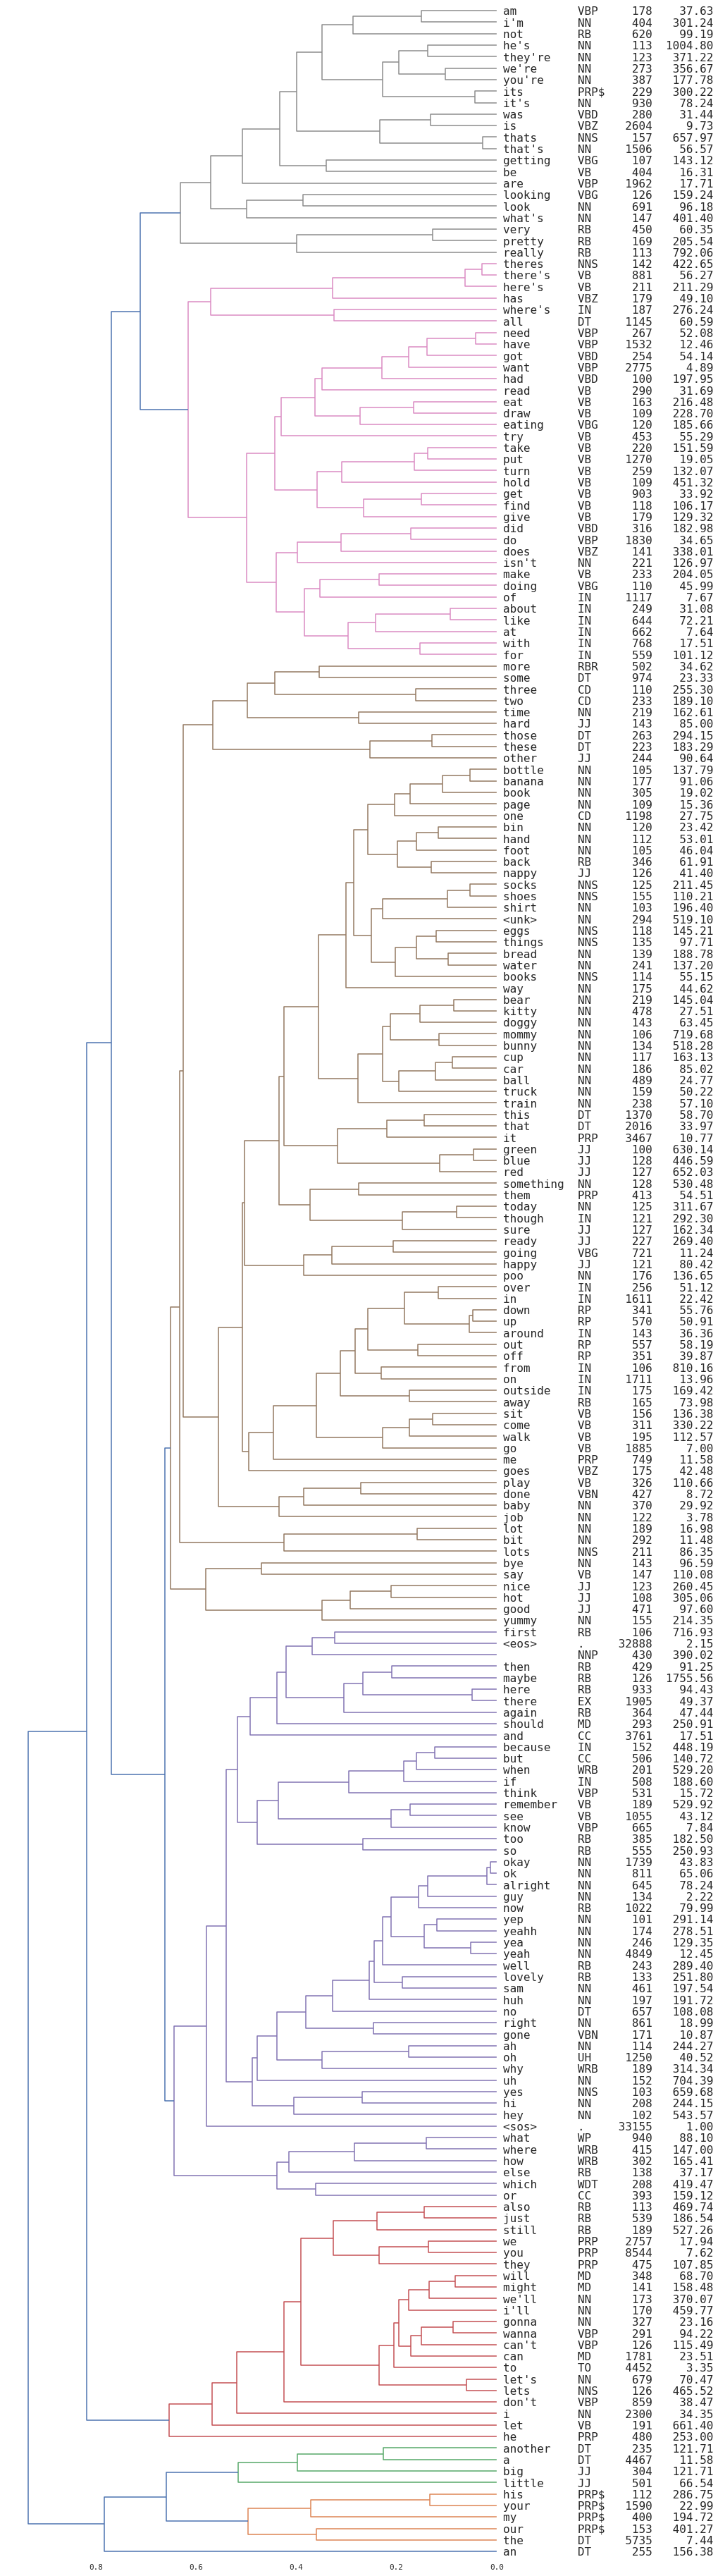

In [15]:
def llf(index):
    if index < n_samples:
        idx = selected_indices[index]
        return f'{selected_words[index]:<10}' + f' {selected_pos_tags[index]:<4}' + f' {cnts[idx].item():6}' + f' {exp(losses[idx].item()):8.2f}' # f' {exp(seed_1_losses[idx].item()):8.2f}{(exp(seed_2_losses[idx].item()) - exp(seed_1_losses[idx].item()):+8.2f}'
    else:
        return f'{index - n_samples} {int(Z[index - n_samples, 3])} {Z[index - n_samples, 2]:.3f}'

p = 10000

plt.figure(figsize=(25 / 2, 0.3 * min(p, n_samples))) # 0.1
_ = dendrogram(
    Z,
    truncate_mode='lastp',
    p=p,
    orientation='left',
    leaf_rotation=0.,
    leaf_font_size=16.,
    leaf_label_func=llf,
)

In [16]:
from sklearn.manifold import TSNE
def get_coordinates(vectors):
    tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto', n_iter=1000, metric='cosine')
    points = tsne.fit_transform(vectors)
    return points
points = get_coordinates(selected_vectors)

/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


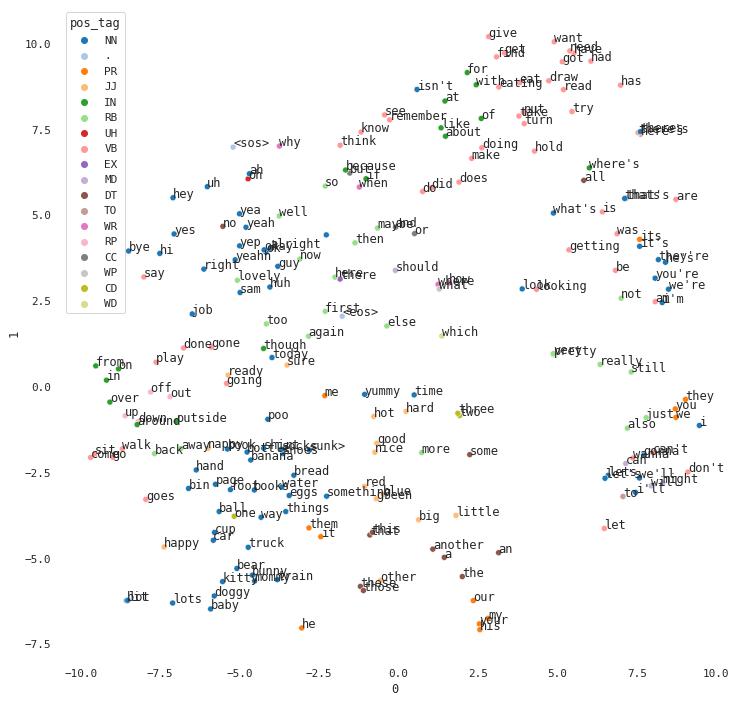

In [17]:
def pos_mapping(pos):
    pos = pos[:2]
    return pos
#plt.scatter(points[:, 0], points[:, 1], s=10)
data = pd.DataFrame(points)
data['word'] = selected_words
data['pos_tag'] = [pos_mapping(pos) for pos in selected_pos_tags]
sns.scatterplot(data=data, x=0, y=1, hue='pos_tag', palette='tab20')
for word, point in zip(selected_words, points):
    plt.text(point[0], point[1], word)